### Верхнеуровневое описание проекта

Нужно решить задачу матчинга.\
Матчинг - это поиск наиболее похожих товаров.\
Сопоставляя товары, можно определять оптимальную цену и сравнивать предложения с предложениями конкурентов, «склеивать» карточки одного и того же товара, который предлагают несколько продавцов.

Данные о товарах уже представлены в виде векторов, т.е мы решаем задачу векторного поиска.\
Векторный поиск - сравнение координат векторов на предмет похожести (близкого положения в пространстве).
    
### Что делаем технически

Мы разработаем алгоритм, который для всех товаров из коллекции validation предложит несколько вариантов наиболее похожих товаров из коллекции base. И оценим качество алгоритма по метрике accuracy@5.


### Задачи

1) Изучение и предобработка данных
2) Создание и обучение модели
3) Оформление решения в виде [репозитория на GitHub](https://github.com/MashaMelyashinskaya/Piggy_bank/tree/main/Matching(vector_distance))

### Данные

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

In [1]:
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import timeit

In [2]:
base = pd.read_csv('F:\\Развитие\\DS\\Хакатоны\\Матчинг_2\\base.csv', index_col = 0)
train_0 = pd.read_csv('F:\\Развитие\\DS\\Хакатоны\\Матчинг_2\\train.csv', index_col = 0)
valid = pd.read_csv('F:\\Развитие\\DS\\Хакатоны\\Матчинг_2\\validation.csv', index_col = 0)
targets = train_0["Target"]
train = train_0.drop("Target", axis=1)
targets_v = pd.read_csv('F:\\Развитие\\DS\\Хакатоны\\Матчинг_2\\validation_answer.csv', index_col = 0)
targets_v = targets_v['Expected']
train_0 = train_0.set_index('Target')

### 1. Изучение и предобработка данных

<Axes: >

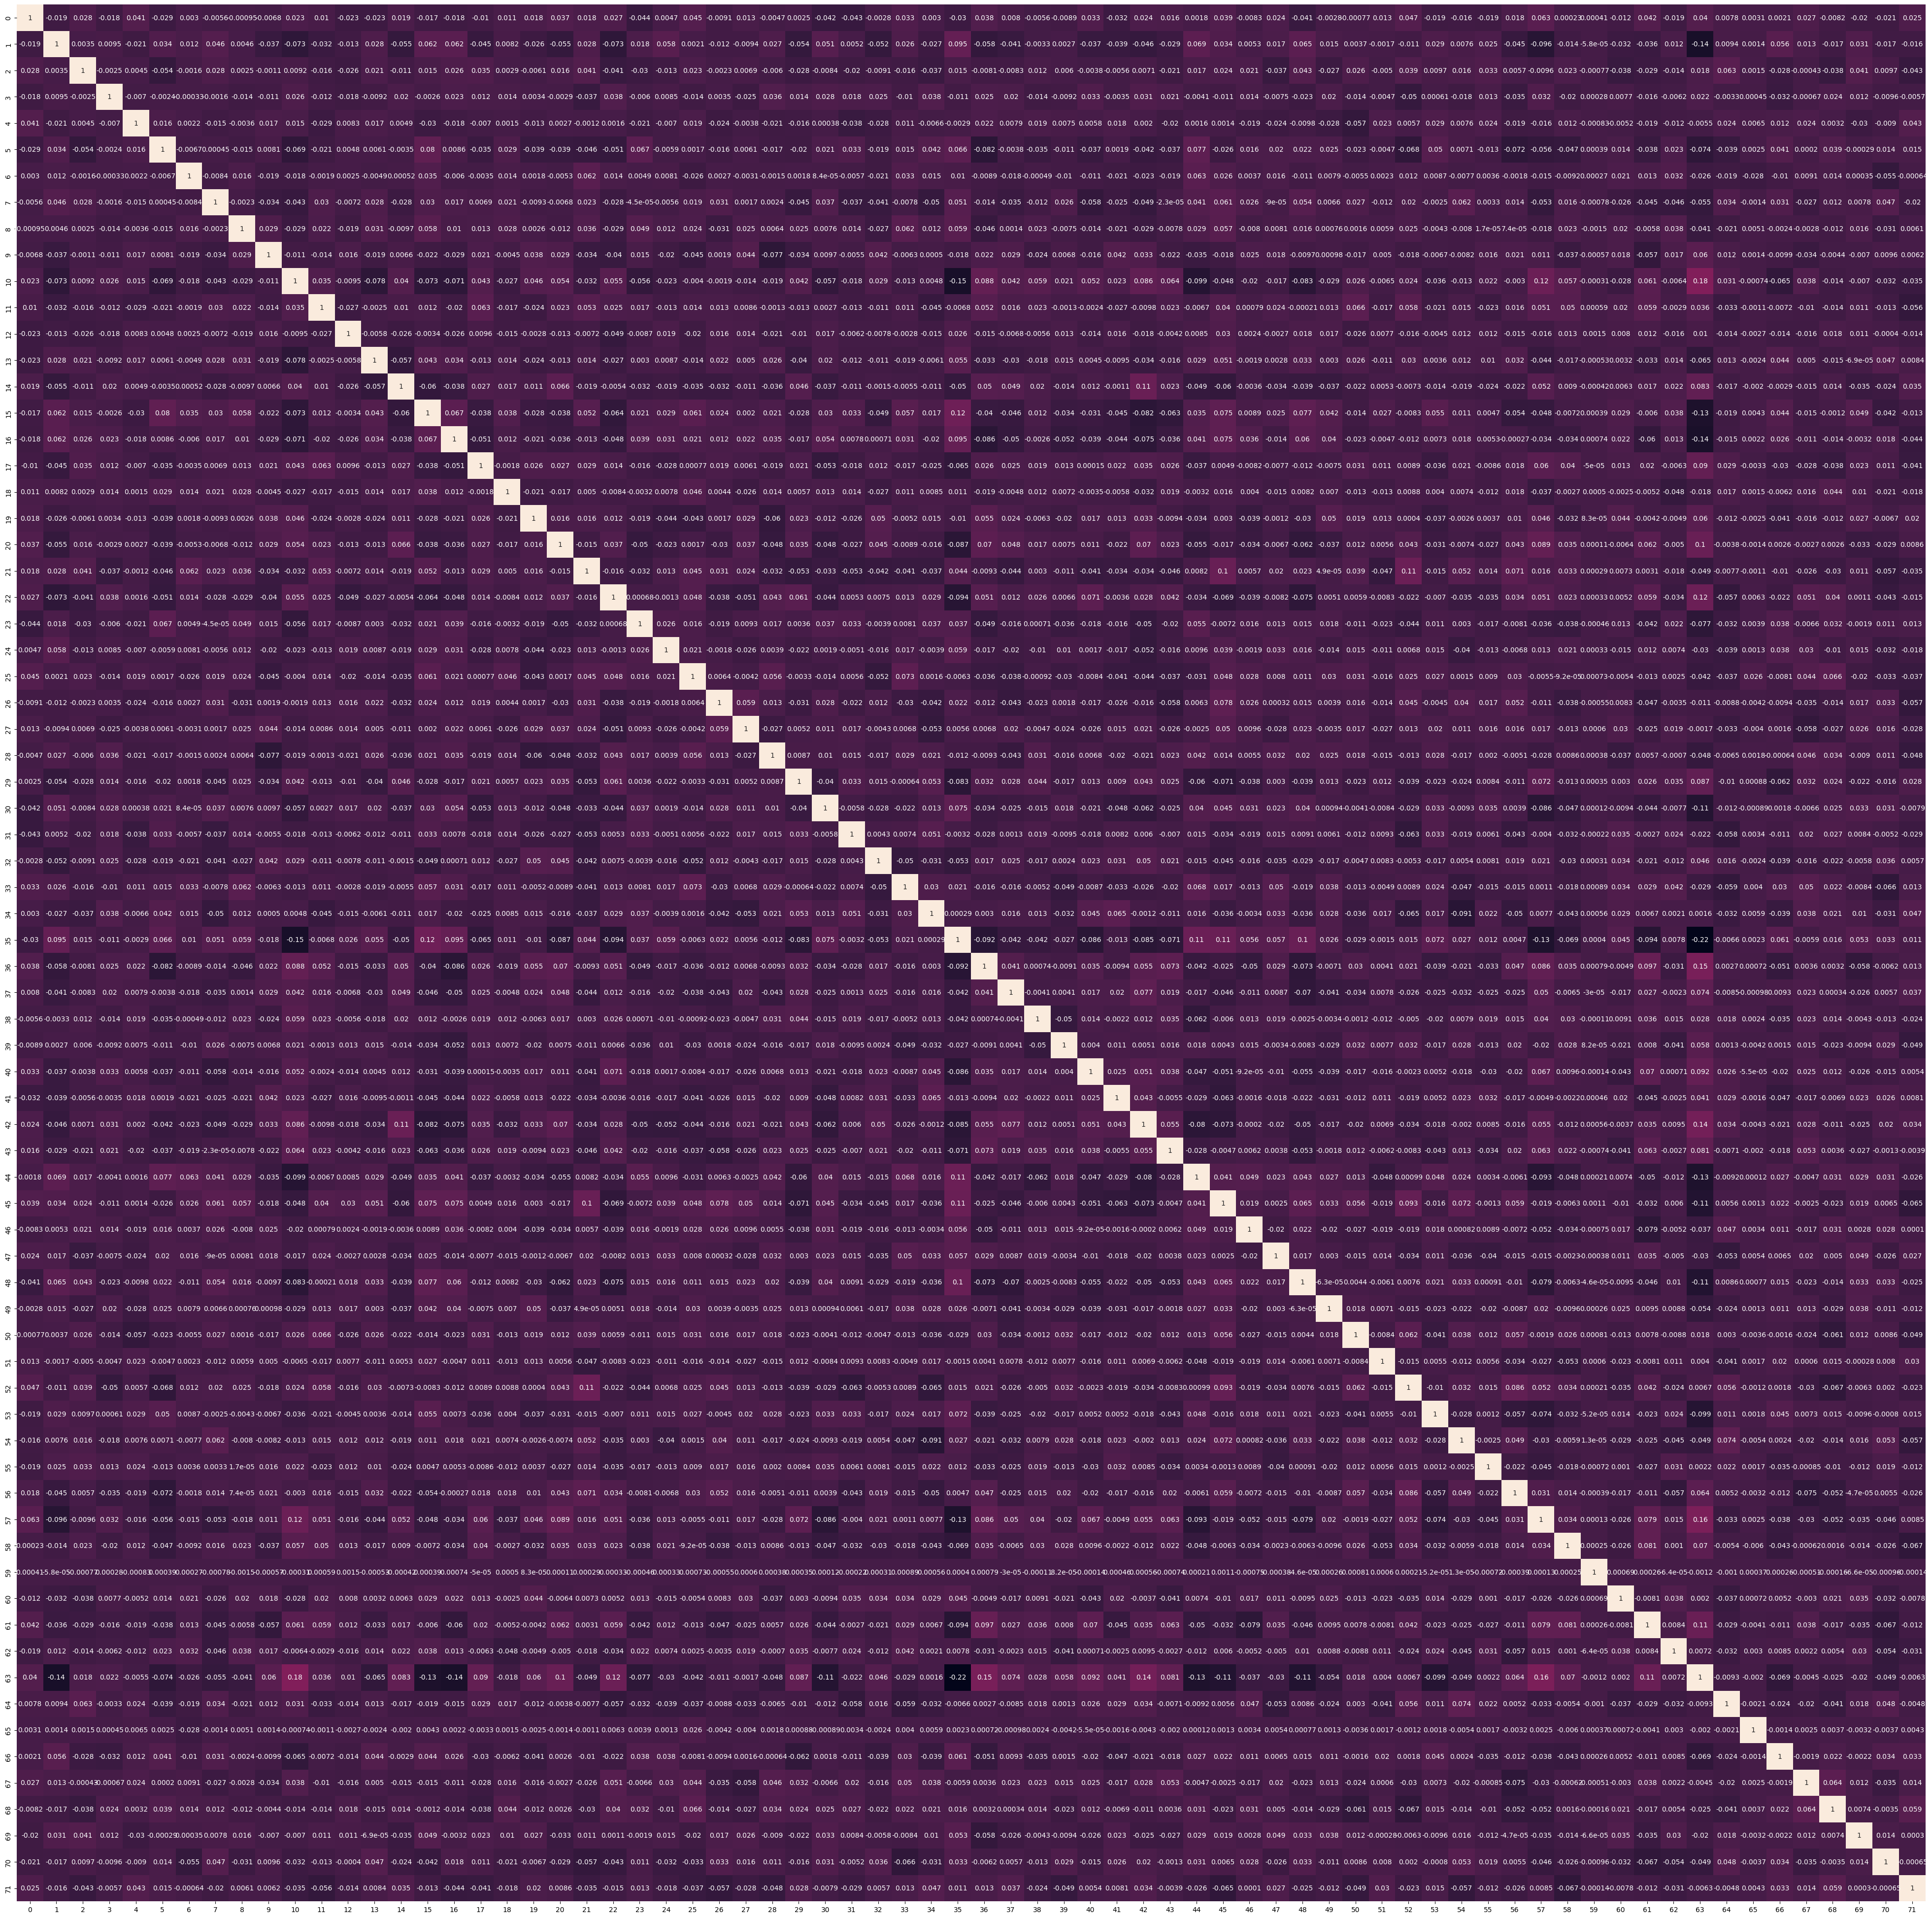

In [3]:
#Посмотрим, нет ли в base мультиколлинеарности
plt.figure(figsize = (50, 50))
sns.heatmap(base.corr(), annot = True, cbar = False)

In [4]:
#Посчитаем корреляцию между каждой координатой совпадающих Id из train и base
#Объединенный датасет для совпадающих векторов из base и train
result = pd.merge(train_0, base, left_index=True, right_index=True)

lst = []
for i in range(0, 72):
    x = str(i) + '_x'
    y = str(i) + '_y'
    k = result[x].corr(result[y])
    lst.append(k)
    corr = pd.DataFrame(lst, columns = ['CoefCorr'])
corr.query('CoefCorr < 0.5')

,CoefCorr
21,0.326845
25,0.362477
33,-0.063766
59,0.000752
65,0.295401


Мультиколлинеарности нет.\
Видим низкие (<0.5) коэффициенты корреляции между 21,25,33,59 и 65 признаками.\
Удалим из модели - они не влияют на сходство векторов.\
P.S. Проводила обучение faiss на разных комбинациях признаков. Удаление этих признаков действительно дает ощутимый прирост метрики качества.

In [5]:
base.drop(['21', '25', '33', '59', '65'], axis = 1, inplace = True)
train.drop(['21', '25', '33', '59', '65'], axis = 1, inplace = True)
valid.drop(['21', '25', '33', '59', '65'], axis = 1, inplace = True)

Также видно, что средние значения признаков разные, значит используем StandardScaler.
Предварительно сохранив в словарь индексы и Id base (еще понадобятся).

In [6]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [7]:
scaler = StandardScaler()
scaler.fit(base)
base_scaled = scaler.transform(base)
train_scaled = scaler.transform(train)
valid_scaled = scaler.transform(valid)

### 2. Создание и обучение модели

#### 2.1 Faiss L2 (векторное сходство)

Пробовала применить косинусное сходство вместо евклидова расстояния, прироста скора не наблюдала. Поэтому таки L2.

In [8]:
#Создадим индекс faiss L2

#количество признаков
dim = base.shape[1]
#количество кластеров
k = 1000
#сколько ближайших соседей
topn = 5
#сколько кластеров проверяем
nprobe = 20

quantiser = faiss.IndexFlatL2(dim) 
index = faiss.IndexIVFFlat(quantiser, dim, k)

In [9]:
#Обучим индекс на base
index.train(base_scaled)
index.add(base_scaled)

In [10]:
#Применим обученный индекс на train
start_time = timeit.default_timer()
index.nprobe = nprobe
D, I = index.search(train_scaled, topn) 
elapsed = timeit.default_timer() - start_time
print(f'Время отработки {elapsed/60:.1f} мин.')

Время отработки 1.8 мин.


In [11]:
#Посчитаем accuracy на train
acc = 0
for target, el in zip(targets.values.tolist(), I.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(f'Accuracy train = {100 * acc / len(I):.0f}%')

Accuracy train = 71%


In [12]:
#Применим обученный индекс на valid
start_time = timeit.default_timer()
D_v, I_v = index.search(valid_scaled, topn)
elapsed = timeit.default_timer() - start_time
print(f'Время отработки {elapsed/60:.1f} мин.')

Время отработки 1.7 мин.


In [13]:
#Посчитаем accuracy на valid
acc = 0
for target, el in zip(targets_v.values.tolist(), I_v.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy valid = {100 * acc / len(I_v):.0f}%')

Accuracy valid = 70%


**ИТОГО** - мы создали модель, которая находит 5 товаров, похожих на наш.\
В 70% случаев среди них находится товар, идеально соответсвующий искомому по мнению экспертов.